In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold 
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.metrics import roc_auc_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingRegressor
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV, RidgeCV, LassoCV, Ridge, Lasso
import lightgbm as lgb

%matplotlib inline

In [4]:
# Удалить отступ у строки заголовка
train = pd.read_csv('data/train.csv', sep='\t', index_col=0)
test = pd.read_csv('data/test.csv', sep='\t', index_col=0)
test = test.iloc[:, 1:]       # убираем 0 столбец таргет

seed = 42

In [5]:
# Разбиение на трейн и таргет
X = train.iloc[:,1:]
y = train.iloc[:,0]
# Разбиение на трейн и валидацию
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=seed, shuffle=True, stratify=y)

### Нейросеть

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, models, transforms
from time import time
import copy

torch.random.manual_seed(seed);
torch.cuda.manual_seed(seed) 

In [7]:
# This is a little utility that we'll use to reset the model if we want to re-initialize all our parameters
def reset(m):
    if hasattr(m, 'reset_parameters'):
        m.reset_parameters()    

In [48]:
#Dataset for PyTorch
class ModulDataset(Dataset):
    def __init__(self, x, y=None, transform=None):
        self.transform = transform
        self.x = x
        self.y = y.values
        
    def __len__(self):
        return self.x.shape[0]
    
    def __getitem__(self, idx):
        sample = self.x.iloc[idx].values
        #sample = torch.from_numpy(sample)
        target = self.y[[idx]]
        #target = self.y[self.y.index[idx]]
        #target = torch.from_numpy(np.asarray(self.y[self.y.index[idx]]).reshape([1,1]))
        #target = torch.from_numpy(target)
        out = (sample, target)
        return out

In [118]:
def train_model(model, criterion, optimizer, scheduler=None, num_epochs=2):
    since = time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    best_epoch = 0
    loss_log = {'train':{}, 'val':{}}
    acc_log = {'train':{}, 'val':{}}
    train_log = []
    val_log = []
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        
        model.train(True)
        
        running_loss = 0.0
        running_corrects = 0
        
        for data in train_load:
            optimizer.zero_grad()
            inputs, labels = data
            inputs = Variable(inputs.cuda()).float()
            labels = Variable(labels.cuda()).float()
            outputs = model(inputs)
            _, preds = torch.max(outputs.data, 1)
            loss = criterion(outputs, labels)
        
            loss.backward()
            optimizer.step()
            
            running_loss += loss.data[0] * inputs.size(0)
            #running_corrects += torch.sum(preds == labels.data)
        
        epoch_loss = running_loss / len(train_set)
        #epoch_acc = running_corrects / len(train_set)
        #print('Train Loss: {:.4f} Acc: {:.4f}'.format(epoch_loss, epoch_acc))
        print('Train Loss: {:.4f}'.format(epoch_loss))
        '''
        train_acc = roc_auc_score(y_train, y_pred.cpu().data.numpy())
        print('train_roc_auc: ', train_acc)
        loss_log['train'][epoch] = loss
        acc_log['train'][epoch] = train_acc
        train_log.append(train_acc)
        '''

        running_loss = 0.0
        running_corrects = 0
        
        for data in valid_load:
            model.train(False)
            optimizer.zero_grad()  
            inputs, labels = data
            inputs = Variable(inputs.cuda()).float()
            labels = Variable(labels.cuda()).float()
            outputs = model(inputs)
            loss = loss_fn(outputs, labels)
            
            #running_loss += loss.data[0] * inputs.size(0)
            #running_corrects += torch.sum(y_pred == labels.data)
            
        #epoch_loss = running_loss / len(valid_set)
        #epoch_acc = running_corrects / len(valid_set)
        #print('Val Loss: {:.4f} Acc: {:.4f}'.format(epoch_loss, epoch_acc))
       
        '''
        val_acc = roc_auc_score(y_val, y_pred.cpu().data.numpy())
        print('val_roc_auc: ', val_acc)
        loss_log['val'][epoch] = loss
        acc_log['val'][epoch] = val_acc
        val_log.append(val_acc)
        '''
        
        #if epoch_acc > best_acc:
        #    best_acc = epoch_acc
        #    best_epoch = epoch
        
        print()
        
    print('Best val Acc: {:4f}, epoch {:d}'.format(best_acc, best_epoch))    
    #plt.plot(train_log)
    #plt.plot(val_log)
    #plt.legend(['train', 'val'])
        
    return model, train_log, val_log

In [93]:
batch_size = 1024
transform_data = transforms.Compose([transforms.ToTensor()])

train_set = ModulDataset(X_train, y_train, transform_data)
valid_set = ModulDataset(X_val, y_val, transform_data)

train_load = DataLoader(train_set,batch_size=batch_size, pin_memory=True)
valid_load = DataLoader(valid_set,batch_size=batch_size, pin_memory=True)

In [122]:
model = nn.Sequential(nn.Linear(345,1024),
                             nn.ReLU(),
                             nn.Linear(1024, 1))

loss_fn = nn.MSELoss()
model = model.cuda()

In [123]:
%%time
optimizer_ft = optim.Adam(model.parameters(), lr=0.001)
#optimizer_ft = optim.SGD(model.parameters(), lr=0.0001)
model.apply(reset)
model_1, train_log, val_log = train_model(model, loss_fn, optimizer_ft, num_epochs=5)

Epoch 0/4
----------
Train Loss: 0.1498

Epoch 1/4
----------
Train Loss: 0.1313

Epoch 2/4
----------
Train Loss: 0.1287

Epoch 3/4
----------
Train Loss: 0.1271

Epoch 4/4
----------
Train Loss: 0.1256

Best val Acc: 0.000000, epoch 0
Wall time: 34.1 s


In [100]:
for i, data in enumerate(valid_load):
    if i == 0:
        inp , tar = data

In [101]:
model.train(True)
inputs = Variable(inp.cuda()).float()
labels = Variable(tar.cuda()).float()

In [102]:
y_pred = model(inputs)

In [103]:
y_pred

Variable containing:
-0.0529
 0.0317
 0.0257
   ⋮    
-0.0263
 0.0053
 0.0798
[torch.cuda.FloatTensor of size 1024x1 (GPU 0)]

In [106]:
labels.data


    0
    0
    1
  ⋮   
    1
    0
    0
[torch.cuda.FloatTensor of size 1024x1 (GPU 0)]

In [81]:
loss = loss_fn(y_pred, labels)

In [82]:
loss

Variable containing:
 24.8962
[torch.cuda.FloatTensor of size 1 (GPU 0)]

In [12]:
use_gpu = True
#Train model
def train_model(model, criterion, optimizer, scheduler=None, num_epochs=2):
    since = time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    best_epoch = 0
    loss_log = {'train':{}, 'val':{}}
    acc_log = {'train':{}, 'val':{}}

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                if scheduler is not None:
                    scheduler.step()
                model.train(True)  # Set model to training mode
            else:
                model.train(False)  # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for data in dataloaders[phase]:
                # get the inputs
                inputs, labels = data

                # wrap them in Variable
                if use_gpu:
                    inputs = Variable(inputs.cuda())
                    labels = Variable(labels.cuda())
                else:
                    inputs, labels = Variable(inputs), Variable(labels)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                outputs = model(inputs)
                _, preds = torch.max(outputs.data, 1)
                loss = criterion(outputs, labels)

                # backward + optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

                # statistics
                running_loss += loss.data[0] * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
            
            loss_log[phase][epoch] = epoch_loss
            acc_log[phase][epoch] = epoch_acc 

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                best_epoch = epoch
        print('lr: ',optimizer.param_groups[0]['lr'])
        print()

    time_elapsed = time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}, epoch {:d}'.format(best_acc, best_epoch))
    

    # load best model weights
    model.load_state_dict(best_model_wts)
    
    # plot graphs
    for phase in loss_log:
        lists = sorted(loss_log[phase].items()) # sorted by key, return a list of tuples
        x, y = zip(*lists) # unpack a list of pairs into two tuples
        plt.figure(1)
        plt.plot(x,y)
    plt.legend(['train', 'val'])
    plt.title('Loss')
    
    for phase in acc_log:
        lists = sorted(acc_log[phase].items()) # sorted by key, return a list of tuples
        x, y = zip(*lists) # unpack a list of pairs into two tuples
        plt.figure(2)
        plt.plot(x,y)
    plt.legend(['train', 'val'])
    plt.title('Accuracy')
    
    return model, loss_log, acc_log

In [6]:
def train_model(model, criterion, optimizer, scheduler=None, num_epochs=2):
    since = time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    best_epoch = 0
    loss_log = {'train':{}, 'val':{}}
    acc_log = {'train':{}, 'val':{}}
    train_log = []
    val_log = []
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        
        model.train(True)
        optimizer.zero_grad()
        y_pred = model(x_t)
        loss = criterion(y_pred, y_t)
        
        loss.backward()
        optimizer.step()
        
        train_acc = roc_auc_score(y_train, y_pred.cpu().data.numpy())
        print('train_roc_auc: ', train_acc)
        loss_log['train'][epoch] = loss
        acc_log['train'][epoch] = train_acc
        train_log.append(train_acc)
        
        model.train(False)
        optimizer.zero_grad()    
        y_pred = model(x_v)
        loss = loss_fn(y_pred, y_v)
        
        val_acc = roc_auc_score(y_val, y_pred.cpu().data.numpy())
        print('val_roc_auc: ', val_acc)
        loss_log['val'][epoch] = loss
        acc_log['val'][epoch] = val_acc
        val_log.append(val_acc)
        
        if val_acc > best_acc:
            best_acc = val_acc
            best_epoch = epoch
        
        print()
    print('Best val Acc: {:4f}, epoch {:d}'.format(best_acc, best_epoch))    
    plt.plot(train_log)
    plt.plot(val_log)
    plt.legend(['train', 'val'])
        
    return model, train_log, val_log

In [9]:
model = nn.Sequential(nn.Linear(345,1024),
                             nn.ReLU(),
                             nn.Linear(1024, 1))

loss_fn = nn.MSELoss(size_average=False)

In [7]:
#x = Variable(torch.randn(1000, 345))
#y = Variable(torch.randn(1000, 1), requires_grad=False)

x_t = Variable(torch.from_numpy(X_train.values).cuda()).float()
y_t = Variable(torch.from_numpy(y_train.values).cuda(), requires_grad=False).float()

x_v = Variable(torch.from_numpy(X_val.values).cuda()).float()
y_v = Variable(torch.from_numpy(y_val.values).cuda(), requires_grad=False).float()

torch.autograd.variable.Variable

Epoch 0/79
----------
train_roc_auc:  0.458019311412
val_roc_auc:  0.448279768988

Epoch 1/79
----------
train_roc_auc:  0.454740609551
val_roc_auc:  0.510976655288

Epoch 2/79
----------
train_roc_auc:  0.514420200559
val_roc_auc:  0.614380636891

Epoch 3/79
----------
train_roc_auc:  0.607256440029
val_roc_auc:  0.639569953733

Epoch 4/79
----------
train_roc_auc:  0.636367682039
val_roc_auc:  0.656548878709

Epoch 5/79
----------
train_roc_auc:  0.654627805716
val_roc_auc:  0.670984833518

Epoch 6/79
----------
train_roc_auc:  0.670242080119
val_roc_auc:  0.679062719675

Epoch 7/79
----------
train_roc_auc:  0.679815198519
val_roc_auc:  0.682195992667

Epoch 8/79
----------
train_roc_auc:  0.684257076461
val_roc_auc:  0.684354218451

Epoch 9/79
----------
train_roc_auc:  0.687205911099
val_roc_auc:  0.687463048642

Epoch 10/79
----------
train_roc_auc:  0.690774568179
val_roc_auc:  0.691161997877

Epoch 11/79
----------
train_roc_auc:  0.694583277547
val_roc_auc:  0.693965936293

Ep

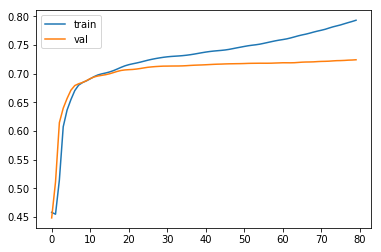

In [10]:
optimizer_ft = optim.Adam(model.parameters(), lr=0.001)
#optimizer_ft = optim.SGD(model.parameters(), lr=0.0001)
model.apply(reset)
model.cuda()
model_1, train_log, val_log = train_model(model, loss_fn, optimizer_ft, num_epochs=80)

#plt.plot(train_log)
#plt.plot(val_log)
#plt.legend(['train', 'val'])

In [7]:
learning_rate = 1e-4

In [10]:
model.apply(reset)
for t in range(10):
  # Forward pass: compute predicted y by passing x to the model. Module objects
  # override the __call__ operator so you can call them like functions. When
  # doing so you pass a Variable of input data to the Module and it produces
  # a Variable of output data.
    y_pred = model(x.float())

  # Compute and print loss. We pass Variables containing the predicted and true
  # values of y, and the loss function returns a Variable containing the loss.
    loss = loss_fn(y_pred, y.float())
    print(t, loss.data[0])
  
  # Zero the gradients before running the backward pass.
    
    model.zero_grad()

  # Backward pass: compute gradient of the loss with respect to all the learnable
  # parameters of the model. Internally, the parameters of each Module are stored
  # in Variables with requires_grad=True, so this call will compute gradients for
  # all learnable parameters in the model.
    loss.backward()

  # Update the weights using gradient descent. Each parameter is a Variable, so
  # we can access its data and gradients like we did before.
    for param in model.parameters():
        param.data -= learning_rate * param.grad.data

0 4967.427734375
1 46516404.0
2 1347620608.0
3 21373945856.0
4 321687322624.0
5 4842453991424.0
6 72886601646080.0
7 1097200264282112.0
8 1.6525956118216704e+16
9 2.4867726640860365e+17


In [101]:
x = torch.linspace(1, 10, 10)       # this is x data (torch tensor)
y = torch.linspace(10, 1, 10)       # this is y data (torch tensor)

In [105]:
type(x.cuda())

torch.cuda.FloatTensor

In [ ]:
y_pred = model(x)

In [50]:
use_gpu = True

In [84]:
#a = X_train.iloc[0].values
a = y_train[y_train.index[0]]
#a = a.astype('float')
type(a)

numpy.int64

In [85]:
b = torch.from_numpy(a)
type(b)

RuntimeError: from_numpy expects an np.ndarray but got numpy.int64

In [75]:
c = b.cuda()
type(c)

torch.cuda.DoubleTensor

In [ ]:
simple_model = nn.Sequential(nn.Linear(345,1024),
                             nn.Linear(1024, 1))

In [48]:
#Train model
def train_model(model, criterion, optimizer, scheduler=None, num_epochs=2):
    since = time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    best_epoch = 0
    loss_log = {'train':{}, 'val':{}}
    acc_log = {'train':{}, 'val':{}}

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                if scheduler is not None:
                    scheduler.step()
                model.train(True)  # Set model to training mode
            else:
                model.train(False)  # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for data in dataloaders[phase]:
                # get the inputs
                inputs, labels = data

                # wrap them in Variable
                if use_gpu:
                    inputs = Variable(inputs.cuda())
                    labels = Variable(labels.cuda())
                else:
                    inputs, labels = Variable(inputs), Variable(labels)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                outputs = model(inputs)
                _, preds = torch.max(outputs.data, 1)
                loss = criterion(outputs, labels)

                # backward + optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

                # statistics
                running_loss += loss.data[0] * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
            
            loss_log[phase][epoch] = epoch_loss
            acc_log[phase][epoch] = epoch_acc 

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                best_epoch = epoch
        print('lr: ',optimizer.param_groups[0]['lr'])
        print()

    time_elapsed = time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}, epoch {:d}'.format(best_acc, best_epoch))
    

    # load best model weights
    model.load_state_dict(best_model_wts)
    
    # plot graphs
    for phase in loss_log:
        lists = sorted(loss_log[phase].items()) # sorted by key, return a list of tuples
        x, y = zip(*lists) # unpack a list of pairs into two tuples
        plt.figure(1)
        plt.plot(x,y)
    plt.legend(['train', 'val'])
    plt.title('Loss')
    
    for phase in acc_log:
        lists = sorted(acc_log[phase].items()) # sorted by key, return a list of tuples
        x, y = zip(*lists) # unpack a list of pairs into two tuples
        plt.figure(2)
        plt.plot(x,y)
    plt.legend(['train', 'val'])
    plt.title('Accuracy')
    
    return model, loss_log, acc_log

# This is a little utility that we'll use to reset the model if we want to re-initialize all our parameters
def reset(m):
    if hasattr(m, 'reset_parameters'):
        m.reset_parameters()    

In [43]:
#Dataset for PyTorch
class ModulDataset(Dataset):
    def __init__(self, x, y=None, transform=None):
        self.transform = transform
        self.x = x
        self.y = y
        
    def __len__(self):
        return self.x.shape[0]
    
    def __getitem__(self, idx):
        sample = self.x.iloc[idx].values
        
        target = self.y[self.y.index[idx]]
        out = (sample, target)
        return out

In [97]:
# Neural Network Model (1 hidden layer)
class Net(nn.Module):
    def __init__(self, n_feature, n_hidden, n_output):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(n_feature, n_hidden) 
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(n_hidden, n_output)  
    
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out

In [21]:
net = Net(345, 1024, 2)

In [10]:
X_train.head()

,1,2,3,4,5,6,7,8,9,10,...,336,337,338,339,340,341,342,343,344,345
29430,1,0,0,0,0,0,0.090909,1,0,1,...,0.174412,0,1,0,0,0.000000,1,1,1,1
29132,1,0,0,0,0,0,0.090909,0,0,1,...,0.154625,0,1,0,0,0.444444,1,1,1,1
14578,1,0,0,0,0,0,0.090909,0,0,1,...,0.109160,1,0,0,0,0.000000,1,1,1,1
17872,1,0,0,0,0,0,0.090909,0,0,1,...,0.450414,1,0,0,0,0.000000,1,1,1,1
20144,1,0,0,1,0,0,0.090909,0,0,1,...,0.154625,0,1,0,0,0.444444,1,1,1,0


In [40]:
y_train.index[0]

29430

In [52]:
type(y_train[y_train.index[1]])

numpy.int64

In [54]:
a = X_train.iloc[11].values
type(a)

numpy.ndarray

In [58]:
b = torch.from_numpy(a)
type(b)

torch.DoubleTensor

In [14]:
train_set = ModulDataset(X_train, y_train, transform_data)

In [16]:
len(train_set)

24400

In [18]:
batch_size = 1024
train_load = DataLoader(train_set,batch_size=batch_size, pin_memory=True)

In [19]:
train_load

In [13]:
transform_data = transforms.ToTensor()

In [44]:
X_test = test
y_test = np.zeros_like(X_test)

batch_size = 1024
train_set = ModulDataset(X_train, y_train, transform_data)
train_load = DataLoader(train_set,batch_size=batch_size, pin_memory=True)

valid_set = ModulDataset(X_val, y_val, transform_data)
valid_load = DataLoader(valid_set,batch_size=batch_size, pin_memory=True)

test_set = ModulDataset(X_test, y_test, transform_data)
test_load = DataLoader(test_set,batch_size=1, pin_memory=True)

In [45]:
image_datasets = {'train':train_set, 'val':valid_set}
dataloaders    = {'train':train_load, 'val':valid_load}
dataset_sizes  = {'train':len(train_set), 'val':len(valid_set)}

In [46]:
# Loss and Optimizer
criterion = nn.CrossEntropyLoss()  
optimizer = torch.optim.Adam(net.parameters(), lr=0.1) 

In [23]:
net.train(True)

Net(
  (fc1): Linear(in_features=345, out_features=1024, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=1024, out_features=2, bias=True)
)

In [34]:
for data in train_load:
    print(data)

KeyError: 11

In [24]:
for i, data in enumerate(train_load):
    if i==0:
        inputs, target = data
    else:
        break

KeyError: 11

In [51]:
model, loss_log, acc_log = train_model(net, criterion, optimizer, num_epochs=10)

Epoch 0/9
----------


RuntimeError: Expected object of type Variable[torch.FloatTensor] but found type Variable[torch.cuda.DoubleTensor] for argument #1 'mat1'

In [88]:
x = torch.unsqueeze(torch.linspace(-1, 1, 100), dim=1)  # x data (tensor), shape=(100, 1)
y = x.pow(2) + 0.2*torch.rand(x.size())                 # noisy y data (tensor), shape=(100, 1)

In [89]:
x, y = Variable(x), Variable(y)

In [90]:
net = Net(n_feature=1, n_hidden=10, n_output=1)     # define the network

In [91]:
optimizer = torch.optim.SGD(net.parameters(), lr=0.02)
loss_func = torch.nn.MSELoss()  # the target label is NOT an one-hotted

IndexError: index 1 is out of bounds for axis 1 with size 1

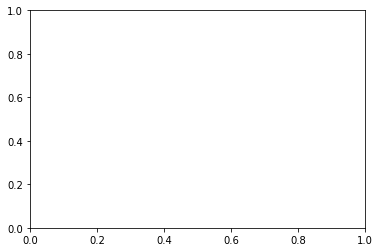

In [92]:
for t in range(100):
    out = net(x)                 # input x and predict based on x
    loss = loss_func(out, y)     # must be (1. nn output, 2. target), the target label is NOT one-hotted

    optimizer.zero_grad()   # clear gradients for next train
    loss.backward()         # backpropagation, compute gradients
    optimizer.step()        # apply gradients

    if t % 2 == 0:
        # plot and show learning process
        plt.cla()
        prediction = torch.max(out, 1)[1]
        pred_y = prediction.data.numpy().squeeze()
        target_y = y.data.numpy()
        plt.scatter(x.data.numpy()[:, 0], x.data.numpy()[:, 1], c=pred_y, s=100, lw=0, cmap='RdYlGn')
        accuracy = sum(pred_y == target_y)/200.
        plt.text(1.5, -4, 'Accuracy=%.2f' % accuracy, fontdict={'size': 20, 'color':  'red'})
        plt.pause(0.1)

Net(
  (fc1): Linear(in_features=1, out_features=10, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=10, out_features=1, bias=True)
)


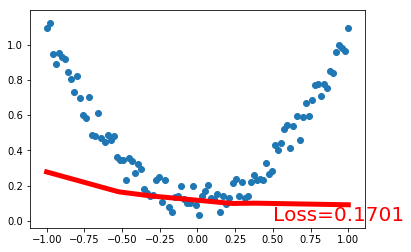

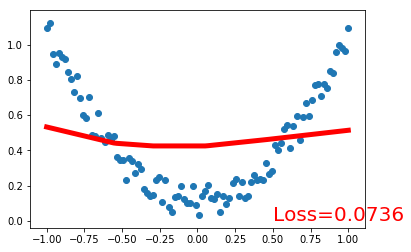

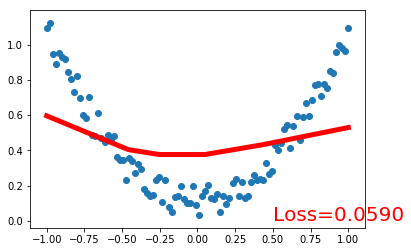

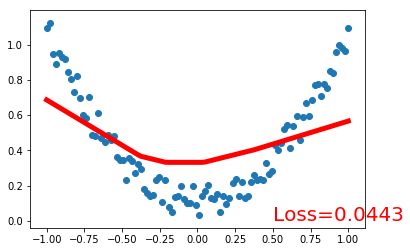

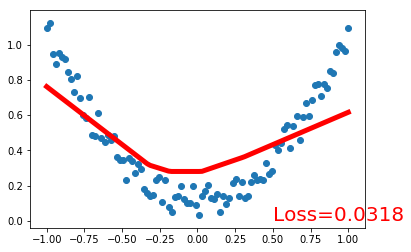

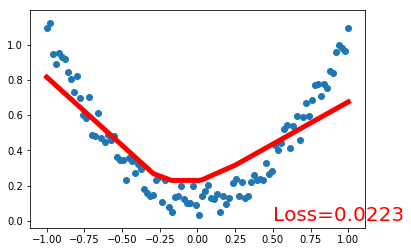

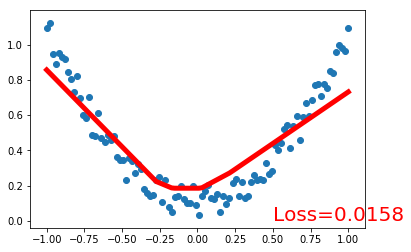

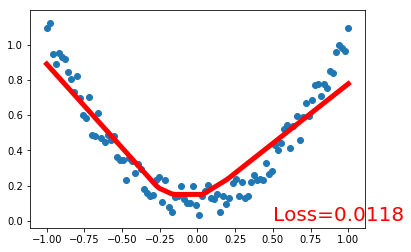

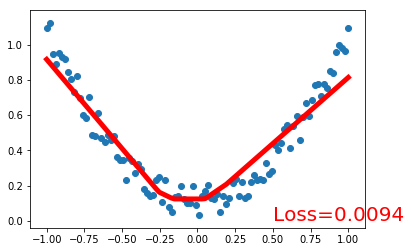

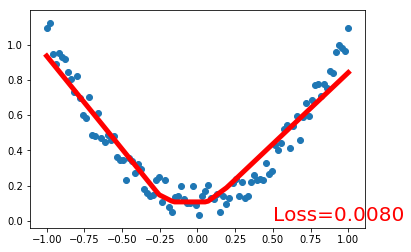

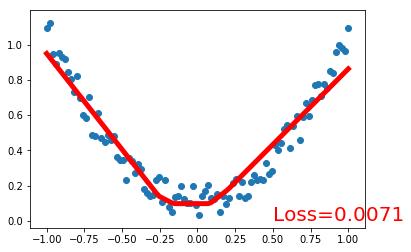

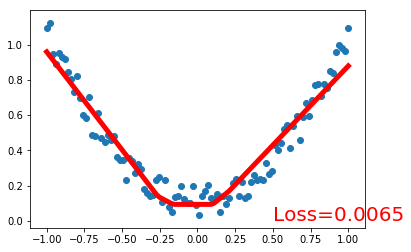

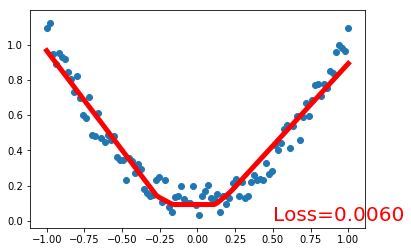

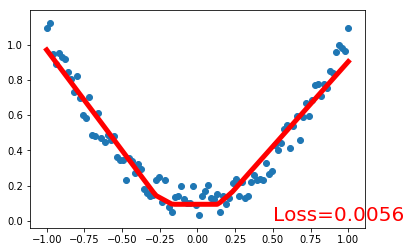

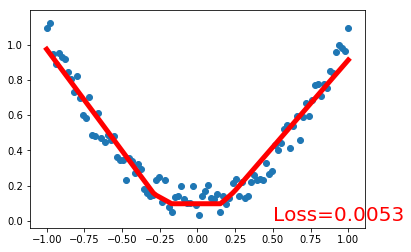

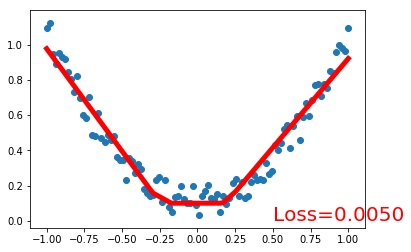

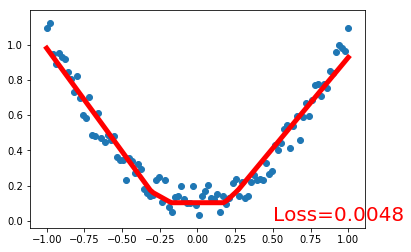

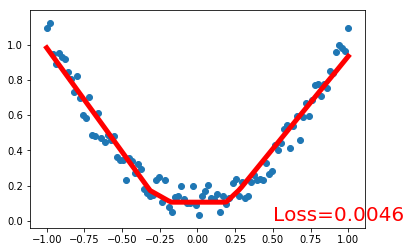

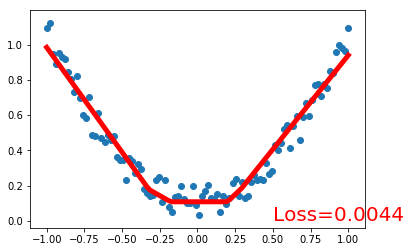

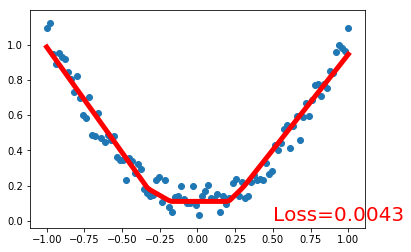

In [98]:
x = torch.unsqueeze(torch.linspace(-1, 1, 100), dim=1)  # x data (tensor), shape=(100, 1)
y = x.pow(2) + 0.2*torch.rand(x.size())                 # noisy y data (tensor), shape=(100, 1)

# torch can only train on Variable, so convert them to Variable
x, y = Variable(x), Variable(y)

# plt.scatter(x.data.numpy(), y.data.numpy())
# plt.show()

net = Net(n_feature=1, n_hidden=10, n_output=1)     # define the network
print(net)  # net architecture

optimizer = torch.optim.SGD(net.parameters(), lr=0.5)
loss_func = torch.nn.MSELoss()  # this is for regression mean squared loss

plt.ion()   # something about plotting

for t in range(100):
    prediction = net(x)     # input x and predict based on x

    loss = loss_func(prediction, y)     # must be (1. nn output, 2. target)

    optimizer.zero_grad()   # clear gradients for next train
    loss.backward()         # backpropagation, compute gradients
    optimizer.step()        # apply gradients

    if t % 5 == 0:
        # plot and show learning process
        plt.cla()
        plt.scatter(x.data.numpy(), y.data.numpy())
        plt.plot(x.data.numpy(), prediction.data.numpy(), 'r-', lw=5)
        plt.text(0.5, 0, 'Loss=%.4f' % loss.data[0], fontdict={'size': 20, 'color':  'red'})
        plt.pause(0.1)

plt.ioff()
plt.show()